# Imports and Dependencies

In [6]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from typing import Literal, Dict, Any

In [7]:
OptionType = Literal["call","put"]

@dataclass
class AmericanStreamingResult:
    price: float
    delta0: float
    boundary_Smin: np.ndarray
    portfolio_error_std: float
    errors: np.ndarray
    params: Dict[str, Any]

# Define Binomial American option

In [8]:
def american_binomial_streaming(S0, K, r, q, sigma, T, N, option: OptionType="put") -> AmericanStreamingResult:
    assert N >= 1
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    a = math.exp((r - q) * dt)
    p = (a - d) / (u - d)
    disc = math.exp(-r * dt)
    ud_ratio = u / d

    # terminal stock price
    base_N = S0 * (d**N)
    i_idx_N = np.arange(N+1)
    S_next = base_N * (ud_ratio ** i_idx_N)
    # terminal payoff
    if option == "call":
        V_next = np.maximum(S_next - K, 0.0)
    else:
        V_next = np.maximum(K - S_next, 0.0)

    S_time1, V_time1 = None, None
    boundary_Smin = np.full(N, np.nan, dtype=float)

    errors = []
    S_time1, V_time1 = None, None
    
    # backward regression
    for j in range(N-1, -1, -1):
        #continue value
        cont = disc * (p * V_next[1:] + (1 - p) * V_next[:-1])
        #stock price
        base_j = S0 * (d**j)
        i_idx_j = i_idx_N[:j+1]
        S_j = base_j * (ud_ratio ** i_idx_j)
        #intrinsic value
        if option == "call":
            intrinsic = np.maximum(S_j - K, 0.0)
        else:
            intrinsic = np.maximum(K - S_j, 0.0)
        V = np.maximum(intrinsic, cont)

        # === Hedging error ===
        if j > 0:  
            delta = (V_next[1:] - V_next[:-1]) / (S_next[1:] - S_next[:-1])
            bond  = disc*(p*V_next[1:] + (1-p)*V_next[:-1]) - delta*(disc*(p*S_next[1:] + (1-p)*S_next[:-1]))
            port_up   = delta*S_next[1:]   + bond
            port_down = delta*S_next[:-1]  + bond
            err_up   = port_up   - V_next[1:]
            err_down = port_down - V_next[:-1]
            errors.extend(err_up.tolist() + err_down.tolist())
        
        exercised = (intrinsic > cont) & (intrinsic > 0)
        if np.any(exercised):
            boundary_Smin[j] = float(np.min(S_j[exercised]))
        if j == 1:
            S_time1, V_time1 = S_j.copy(), V.copy()
        V_next = V
        S_next = S_j

    price0 = float(V_next[0])
    if S_time1 is None or V_time1 is None:
        # N=1 special case
        S_time1 = np.array([S0*d, S0*u])
        if option == "call":
            V_time1 = np.maximum(S_time1 - K, 0.0)
        else:
            V_time1 = np.maximum(K - S_time1, 0.0)
    delta0 = float((V_time1[1] - V_time1[0]) / (S_time1[1] - S_time1[0]))

    errors = np.array(errors)
    portfolio_error_std = float(np.std(errors)) if errors.size > 0 else 0.0

    params = dict(S0=S0, K=K, r=r, q=q, sigma=sigma, T=T, N=N, option=option, dt=dt, u=u, d=d, p=p)
    return AmericanStreamingResult(price=price0, delta0=delta0,
                                   boundary_Smin=boundary_Smin,
                                   portfolio_error_std=portfolio_error_std,
                                   errors=errors,
                                   params=params)

# Parameters

In [11]:
S0 = 100.0
K = 100.0
r = 0.03
q = 0.0
sigma = 0.15
T = 1.0
N = 10000

res_put = american_binomial_streaming(S0, K, r, q, sigma, T, N, option="put")
res_call = american_binomial_streaming(S0, K, r, q, sigma, T, N, option="call")
Mean_error = np.mean(res_put.errors)

print("American Put price =", res_put.price)
print("Delta0 =", res_put.delta0)
print("Portfolio Error Mean =", Mean_error)
print("Portfolio Error StdDev =", res_put.portfolio_error_std)

American Put price = 4.82058231035573
Delta0 = -0.4269803083555643
Portfolio Error Mean = -0.00015007410796119027
Portfolio Error StdDev = 0.00014905294054443327


# Early exercise boundary curve

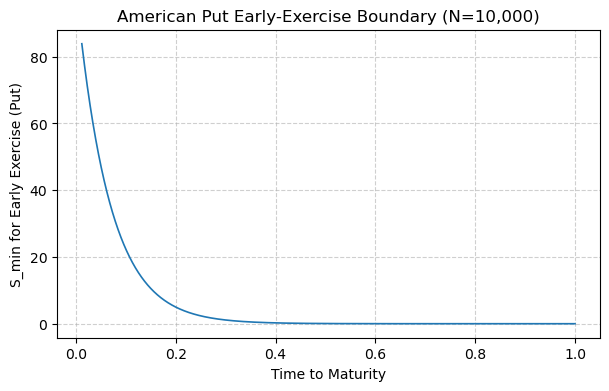

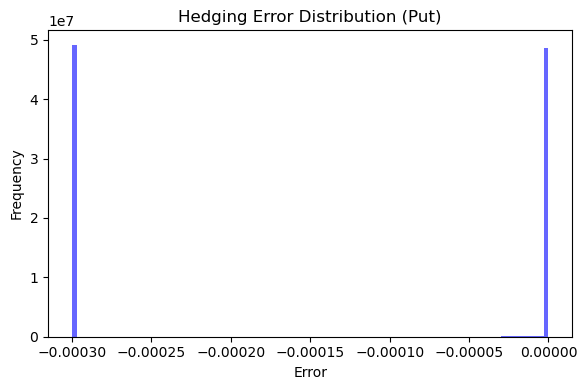

In [30]:
steps = np.arange(N)
times = steps * (T/N)
boundary = res_put.boundary_Smin
exists = ~np.isnan(boundary)

plt.figure(figsize=(7,4))
plt.plot(times[exists], boundary[exists], lw=1.2)
plt.xlabel("Time to Maturity")
plt.ylabel("S_min for Early Exercise (Put)")
plt.title("American Put Early-Exercise Boundary (N=10,000)")
plt.grid(True, ls="--", alpha=0.6)
plt.savefig("American Put Early-Exercise Boundary (N=10,000)")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res_put.errors, bins=100, color="blue", alpha=0.6)
plt.title("Hedging Error Distribution (Put)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Hedging Error Distribution (Put)")
plt.show()